In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import random
sys.path.append(os.path.abspath('./src/'))
from ActivationFunctions import *
from NeuralNetwork import *

from sklearn.preprocessing import MinMaxScaler

RANDOM_STATE = 12345

In [2]:
def multy_plot(datas, labels, title, scale='linear'):
    x = np.arange(0, len(datas[0])).tolist()

    for i, el in enumerate(datas):
        plt.plot(x, el, label=labels[i])


    plt.title(title)
    plt.grid()
    plt.legend()
    plt.yscale(scale)
    plt.show()

In [3]:
def create_dataset(n_items, n_input, input_range, output_functions, seed):
    random.seed(seed)

    n_output = len(output_functions)
    x = np.ndarray((n_items, n_input + n_output))

    for i in range(n_items):
        for l in range(n_input):
            x[i,l] = random.randrange(input_range[0], input_range[1], input_range[2])

        for l, fun in enumerate(output_functions):
            
            x[i, n_input + l] = fun(x[i][:n_input])
            #print(x[i][:n_input], fun(x[i][:n_input]), x[i, l])

    return pd.DataFrame(x, columns = ['input_' + str(i + 1) for i in range(n_input)] + ['output_' + str(i + 1) for i in range(n_output)])

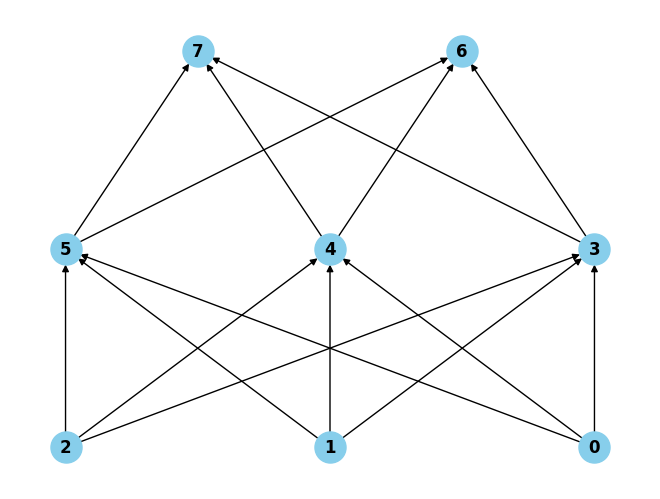

In [4]:
topology_1 = {'0': ['input', 'None', [], ['3', '4', '5']], 
            '1': ['input', 'None', [], ['3', '4', '5']],
            '2': ['input', 'None', [], ['3', '4', '5']],

            '3': ['hidden', 'sigmoid', ['0','1','2'], ['6', '7']],
            '4': ['hidden', 'sigmoid', ['0','1','2'], ['6', '7']],
            '5': ['hidden', 'sigmoid', ['0','1','2'], ['6', '7']],

            '6': ['output', 'identity', ['3','4','5'], []],
            '7': ['output', 'identity', ['3','4','5'], []]}
NeuralNetwork.display_topology(topology_1)

In [5]:
NN = NeuralNetwork(topology_1, -0.75, 0.75, True, RANDOM_STATE)
print(NN)

Instance Attributes:
input_size: 3
output_size: 2
neurons: [InputNeuron(index=2,
	type=input,
	successors=[3, 4, 5, ],
	n_successors=3,
	last_predict=0.0,
	delta_error=0,
	old_weight_update=0,
	w=[0],
	), InputNeuron(index=1,
	type=input,
	successors=[3, 4, 5, ],
	n_successors=3,
	last_predict=0.0,
	delta_error=0,
	old_weight_update=0,
	w=[0],
	), InputNeuron(index=0,
	type=input,
	successors=[3, 4, 5, ],
	n_successors=3,
	last_predict=0.0,
	delta_error=0,
	old_weight_update=0,
	w=[0],
	), HiddenNeuron(index=5,
	type=hidden,
	predecessors=[0, 1, 2, ],
	n_predecessors=3,
	successors=[6, 7, ],
	n_successors=2,
	w=[ 0.12956703  0.33135215 -0.18881571  0.33666086],
	f=<function ActivationFunctions.sigmoid at 0x00000244DD1E3420>,
	f_parameters=[0.0, 1.0, 2.0],
	net=0.0,
	last_predict=0.0,
	delta_error=0.0,
	partial_weight_update=[0. 0. 0. 0.],
	old_weight_update=[0. 0. 0. 0.],
	partial_successors_weighted_errors=0.0,
	), HiddenNeuron(index=4,
	type=hidden,
	predecessors=[0, 1, 2, ],
	n_pred

In [6]:
tr_input = 3
tr_output = 2
len_dataset = 500

f1 = lambda x : x[2]*2 + x[1]*3 - x[0] - 50
f2 = lambda x : x[2]*1.3 - x[1]**2 + x[0]*3 + 25

tr = create_dataset(len_dataset, tr_input, [0, 100, 1], [f1, f2], RANDOM_STATE)
tr.sample(10, random_state=RANDOM_STATE)

,input_1,input_2,input_3,output_1,output_2
272,1.0,61.0,77.0,286.0,-3592.9
244,21.0,59.0,64.0,234.0,-3309.8
271,15.0,68.0,38.0,215.0,-4504.6
381,74.0,90.0,24.0,194.0,-7821.8
52,8.0,96.0,58.0,346.0,-9091.6
48,0.0,18.0,0.0,4.0,-299.0
299,72.0,49.0,53.0,131.0,-2091.1
452,25.0,82.0,23.0,217.0,-6594.1
295,13.0,24.0,93.0,195.0,-391.1
85,38.0,92.0,40.0,268.0,-8273.0


In [7]:
scaler_out = MinMaxScaler()
scaler_in = MinMaxScaler()
scaler_in.fit(tr.values[:,:tr_input])
scaler_out.fit(tr.values[:,tr_input:])
tr_normalized = np.empty((len_dataset, tr_output+tr_input))
tr_normalized[:,:tr_input] = scaler_in.transform(tr.values[:,:tr_input])
tr_normalized[:,tr_input:] = scaler_out.transform(tr.values[:,tr_input:])

In [8]:
tr_normalized

array([[0.53535354, 0.93939394, 0.01010101, 0.54428044, 0.12279247],
       [0.38383838, 0.47474747, 0.24242424, 0.40221402, 0.75703103],
       [0.34343434, 0.72727273, 0.55555556, 0.66236162, 0.46614545],
       ...,
       [0.41414141, 0.1010101 , 0.02020202, 0.11070111, 0.96328763],
       [0.1010101 , 0.8989899 , 0.37373737, 0.73431734, 0.18654307],
       [0.48484848, 0.16161616, 0.56565657, 0.3302583 , 0.95689085]])

In [9]:
training_set = tr.values

batch_size = 20
max_epochs = 500
error_decrease_tolerance = 0.0001
patience = 5

learning_rate = 0.01/batch_size
lambda_tikhonov = 0
alpha_momentum = 0

stats = NN.train_2(tr_normalized, batch_size, max_epochs, error_decrease_tolerance, patience, 
                   learning_rate, lambda_tikhonov, alpha_momentum)

In [10]:
predictions = scaler_out.inverse_transform(NN.predict_array(tr_normalized[:,:tr_input]))
predictions

array([[  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12780825, -2997.90237601],
       [  145.12

In [11]:
for key in list(stats.keys())[:9]:
    print(key, ':', stats[key])

training_set_len : 500
minibatch_size : 20
max_epochs : 500
error_decrease_tolerance : 0.0001
patience : 5
learning_rate : 0.0005
lambda_tikhonov : 0
alpha_momentum : 0
epochs : 21


In [12]:
stats['training_error']

[0.6733783011844232,
 0.5028663556544345,
 0.40931987031145034,
 0.3603720426540957,
 0.3360298634628766,
 0.3245611630277437,
 0.3190813099171082,
 0.3163068426998747,
 0.3148321262592807,
 0.3140133658204818,
 0.3135411320415492,
 0.31326012936066444,
 0.3130888647845959,
 0.3129826478561764,
 0.3129159654937221,
 0.3128737545969284,
 0.31284688651703074,
 0.3128297221360782,
 0.31281873078233563,
 0.3128116815104075,
 0.3128071559637643,
 0.31280424874363744]

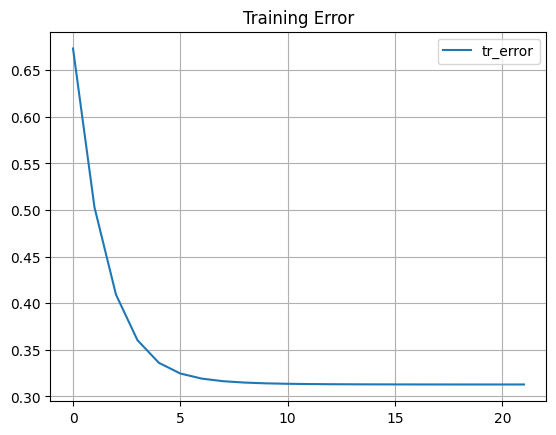

In [13]:
multy_plot([stats['training_error']], ['tr_error'], 'Training Error')

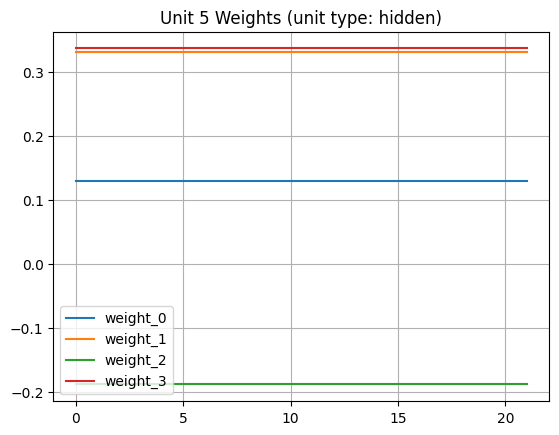

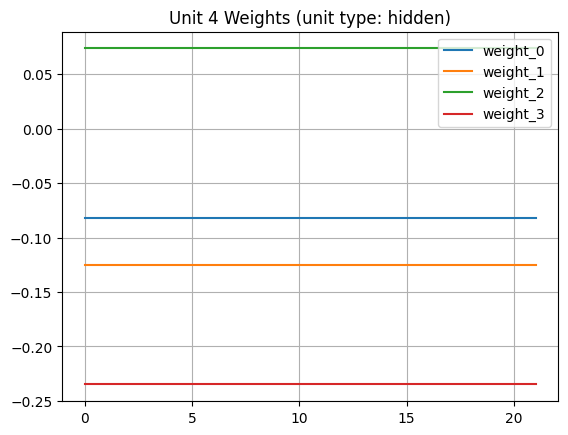

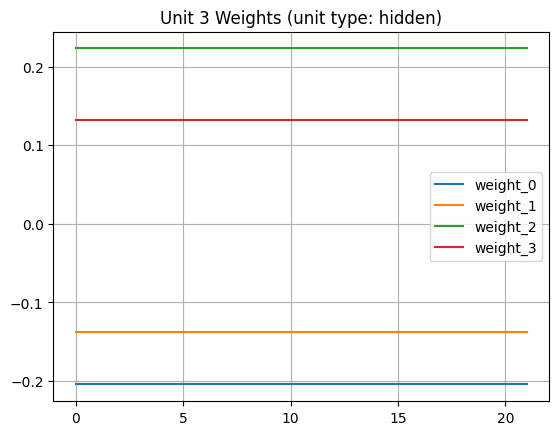

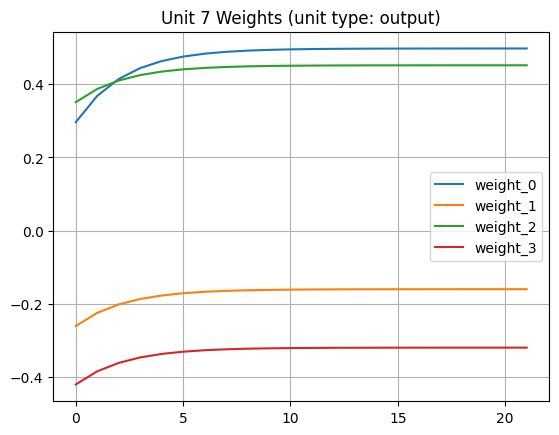

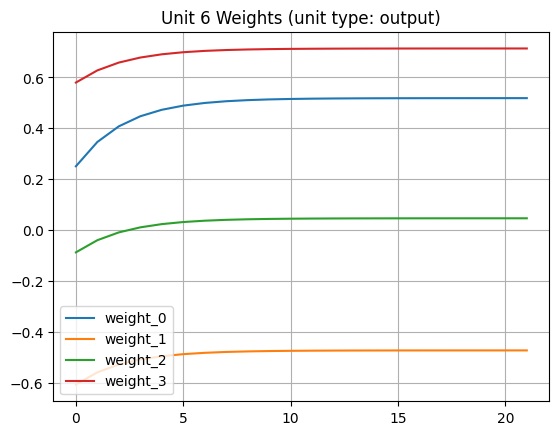

In [14]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

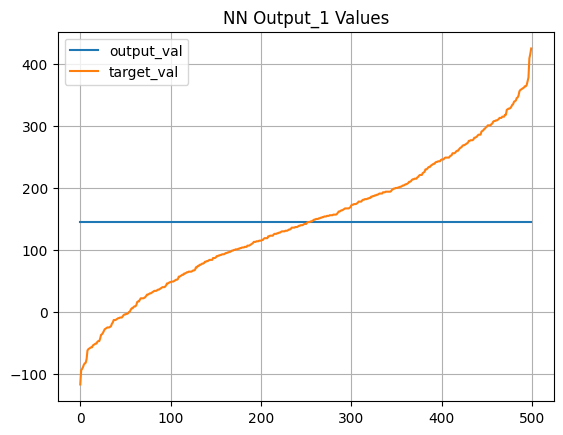

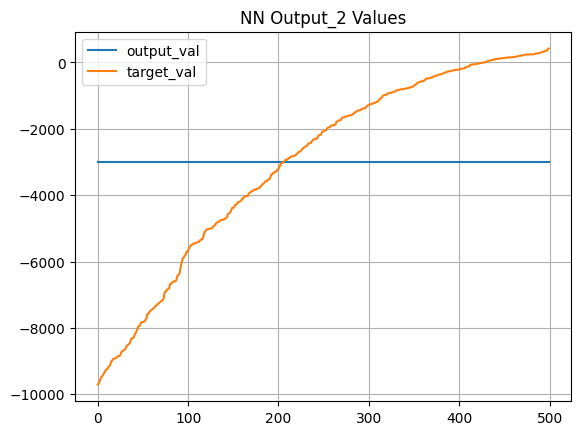

In [15]:
for i in range(tr_output):
    sorted_order = training_set[:, tr_input + i].argsort()
    multy_plot([predictions[sorted_order][:,i] , training_set[sorted_order][:,tr_input + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')